In [5]:

import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /Users/kevinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df=pd.read_csv('spam.csv', encoding='latin')

In [3]:
df['text']=df.v2
df['spam']=df.v1
df=df.drop(['v1','v2','Unnamed: 2','Unnamed: 3', 'Unnamed: 4'],axis=1)

In [4]:
df.head()

,text,spam
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [5]:
def spam_or_ham(x):
    if(x=='ham'):
        return 0
    return 1
df['spam'] = df['spam'].map(lambda x:spam_or_ham(x))

In [6]:
df.head()

,text,spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df["text"].apply(preprocessing)

<Axes: xlabel='spam', ylabel='count'>

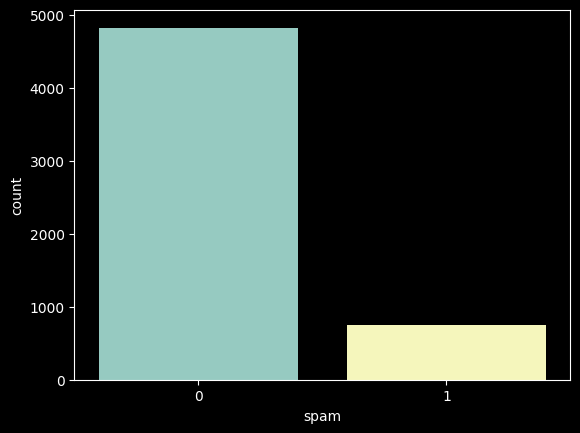

In [102]:
sns.countplot(x=df['spam'])

In [8]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["spam"])

In [9]:
X.head()


0    go jurong point crazy available bugis n great ...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts st ...
3                      dun say early hor c already say
4                  nah think go usf life around though
Name: text, dtype: object

In [10]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [11]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)

In [12]:
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])

Text               :  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Numerical Sequence :  [3, 3575, 255, 549, 522, 1028, 35, 56, 236, 845, 80, 2411, 1029, 9, 3576, 70]
Text               :  ok lar joking wif oni
Numerical Sequence :  [6, 220, 1173, 328, 1539]
Text               :  free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over
Numerical Sequence :  [5, 342, 582, 724, 92, 1540, 846, 478, 1541, 147, 175, 17, 1540, 221, 342, 2412, 23, 2413, 263, 2414]
Text               :  dun say early hor c already say
Numerical Sequence :  [142, 48, 256, 2415, 69, 75, 48]
Text               :  nah think go usf life around though
Numerical Sequence :  [774, 33, 3, 725, 86, 121, 195]


In [13]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[   0,    0,    0, ...,    9, 3576,   70],
       [   0,    0,    0, ..., 1173,  328, 1539],
       [   0,    0,    0, ..., 2413,  263, 2414],
       ...,
       [   0,    0,    0, ..., 1024, 7818, 3573],
       [   0,    0,    0, ...,  789,   67,    5],
       [   0,    0,    0, ..., 2147,  363,  145]], dtype=int32)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sms_sequence, y, test_size=0.33, random_state=42)

In [15]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 32)            250240    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 305481 (1.17 MB)
Trainable params: 305481 

In [16]:
lstm_model.fit(X_train, y_train, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
187/187 [==============================] - 6s 21ms/step - loss: 0.2438 - accuracy: 0.9200 - val_loss: 0.1024 - val_accuracy: 0.9652
Epoch 2/5
187/187 [==============================] - 4s 20ms/step - loss: 0.0372 - accuracy: 0.9913 - val_loss: 0.0729 - val_accuracy: 0.9772
Epoch 3/5
187/187 [==============================] - 4s 20ms/step - loss: 0.0111 - accuracy: 0.9977 - val_loss: 0.1053 - val_accuracy: 0.9732
Epoch 4/5
187/187 [==============================] - 4s 20ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.1458 - val_accuracy: 0.9719
Epoch 5/5
187/187 [==============================] - 4s 20ms/step - loss: 0.0240 - accuracy: 0.9950 - val_loss: 0.0878 - val_accuracy: 0.9759


In [26]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = lstm_model.predict(X_test,batch_size =16)

from sklearn.preprocessing import MultiLabelBinarizer
y_pred= MultiLabelBinarizer().fit_transform(y_pred)
print(np.unique(y_pred, return_counts=True))

#df_test = pd.DataFrame({'true': y_test, 'pred':y_pred.tolist()})

#df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
#print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
#print(classification_report(df_test.true, df_test.pred))


115/115 [==============================] - 1s 5ms/step
(array([0, 1]), array([3207216,    1839]))


In [25]:
DATASET2

NameError: name 'DATASET2' is not defined

In [57]:
df2=pd.read_csv('balanced_dataset_training.csv', encoding='latin')
df_test=pd.read_csv('balanced_dataset_testing.csv', encoding='latin')

In [58]:
df2.isna().sum()

Unnamed: 0               0
title                    0
location                 9
department             310
salary_range           363
company_profile        249
description              0
requirements            88
benefits               179
telecommuting            0
has_company_logo         0
has_questions            0
employment_type        132
required_experience    189
required_education     230
industry               162
function               177
fraudulent               0
in_balanced_dataset      0
dtype: int64

In [59]:
df2.shape

(450, 19)

In [60]:
def fraudulent(x):
    if(x=='f'):
        return 0
    return 1
df_OD = df2[['fraudulent', 'description']].copy()
df_OD.head()
df_OD['scam'] = df2['fraudulent'].map(lambda x:fraudulent(x))
df_OD['text']= df2['description'].copy()
df_OD.head()

,fraudulent,description,scam,text
0,f,<p>We are looking for a mobile application eng...,0,<p>We are looking for a mobile application eng...
1,f,<p>This fast growing company specialized in da...,0,<p>This fast growing company specialized in da...
2,t,<p>SUMMARYResponsible for acting as a liaison ...,1,<p>SUMMARYResponsible for acting as a liaison ...
3,t,<p>ÃÂÃÂ In addition to clerical and adminis...,1,<p>ÃÂÃÂ In addition to clerical and adminis...
4,f,<p>Are you looking for a career that will chal...,0,<p>Are you looking for a career that will chal...


In [61]:
df_OD=df_OD.drop(['fraudulent', 'description'], axis=1)

df_OD.head()
    


,scam,text
0,0,<p>We are looking for a mobile application eng...
1,0,<p>This fast growing company specialized in da...
2,1,<p>SUMMARYResponsible for acting as a liaison ...
3,1,<p>ÃÂÃÂ In addition to clerical and adminis...
4,0,<p>Are you looking for a career that will chal...


In [62]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df_OD["text"].apply(preprocessing)

In [63]:
df_OD.head()


,scam,text
0,0,<p>We are looking for a mobile application eng...
1,0,<p>This fast growing company specialized in da...
2,1,<p>SUMMARYResponsible for acting as a liaison ...
3,1,<p>ÃÂÃÂ In addition to clerical and adminis...
4,0,<p>Are you looking for a career that will chal...


<Axes: xlabel='scam', ylabel='count'>

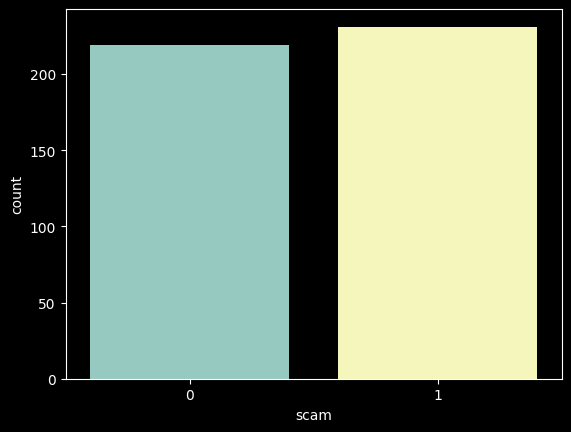

In [64]:
sns.countplot(x=df_OD["scam"])

In [65]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df_OD["scam"])

In [66]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)
print(X)

0      pwe looking mobile application engineer io and...
1      pthis fast growing company specialized data an...
2      psummaryresponsible acting liaison customer co...
3      pin addition clerical administrative duty indi...
4      pare looking career challenge allow make impac...
                             ...                        
445    pprepares source data computer entry compiling...
446    pjob descriptionppbrvertex global solution see...
447    pbapply using linkbppba hrefurlabecbbbaadffccc...
448    pexperienced sale professional onlyppearn plus...
449    ullibdo flair customer engagementblilibare int...
Name: text, Length: 450, dtype: object


In [67]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
len(padded_sms_sequence)

450

In [68]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(30))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "mse", optimizer = "adam", metrics = ["mean_squared_error"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2479, 32)          289152    
                                                                 
 lstm_1 (LSTM)               (None, 30)                7560      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 297353 (1.13 MB)
Trainable params: 29735

In [69]:
history=lstm_model.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
23/23 [==============================] - 16s 603ms/step - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2486 - val_mean_squared_error: 0.2486
Epoch 2/5
23/23 [==============================] - 13s 569ms/step - loss: 0.2407 - mean_squared_error: 0.2407 - val_loss: 0.2240 - val_mean_squared_error: 0.2240
Epoch 3/5
23/23 [==============================] - 13s 582ms/step - loss: 0.1647 - mean_squared_error: 0.1647 - val_loss: 0.1558 - val_mean_squared_error: 0.1558
Epoch 4/5
23/23 [==============================] - 13s 569ms/step - loss: 0.0936 - mean_squared_error: 0.0936 - val_loss: 0.1227 - val_mean_squared_error: 0.1227
Epoch 5/5
23/23 [==============================] - 14s 594ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.1123 - val_mean_squared_error: 0.1123


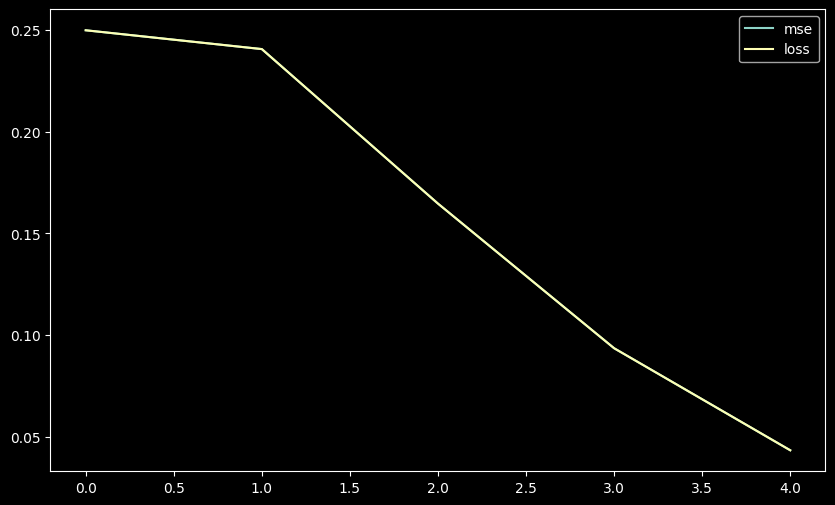

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='mse')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [71]:

df_OD_test = df_test[['fraudulent', 'description']].copy()
df_OD_test.head()
df_OD_test['scam'] = df_test['fraudulent'].map(lambda x:fraudulent(x))
df_OD_test['text']= df_test['description'].copy()
df_OD_test=df_OD_test.drop(['fraudulent', 'description'], axis=1)

X = df_OD_test["text"].apply(preprocessing)

tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)

max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence_test = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence_test


array([[   0,    0,    0, ...,  365,  366,  810],
       [   0,    0,    0, ...,   33, 1068, 2299],
       [   0,    0,    0, ...,  585,  586,  587],
       ...,
       [   0,    0,    0, ...,  770,  526,  946],
       [   0,    0,    0, ...,  956,   50, 3206],
       [   0,    0,    0, ...,   10,  235, 8712]], dtype=int32)

In [72]:
len(padded_sms_sequence_test)

450

In [56]:
pred = lstm_model.predict(padded_sms_sequence_test)
y_pred=[]
for i in range(0,pred.size):
    if pred[i][0] >0.95:
        y_pred.append(1)
    else:
        y_pred.append(0)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

ValueError: in user code:

    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/kevinha/anaconda3/envs/R/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2479), found shape=(None, 2368)


In [133]:
len(y_pred)

450

In [143]:
pred = lstm_model.predict(padded_sms_sequence)
y_pred=[]
for i in range(0,pred.size):
    if pred[i][0] >0.95:
        y_pred.append(1)
    else:
        y_pred.append(0)
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

29/29 [==============================] - 3s 99ms/step


array([[412,  38],
       [ 53, 397]])